<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/learn_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

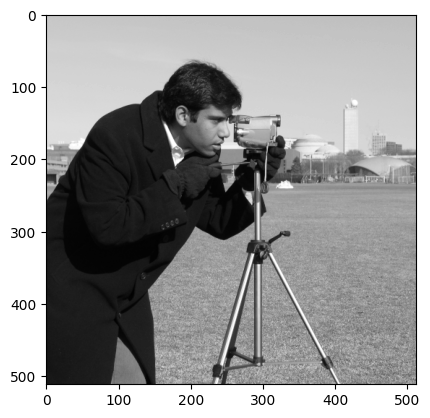

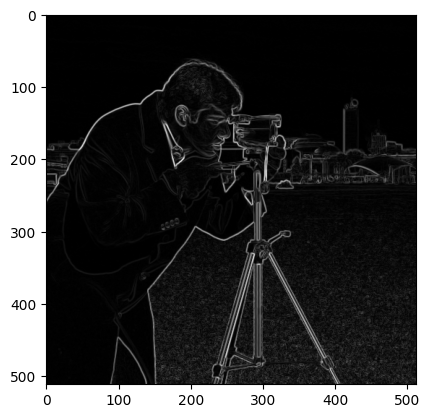

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera

image = camera()
edge_sobel = filters.sobel(image)
plt.figure();plt.imshow(image,cmap='gray')
plt.figure();plt.imshow(edge_sobel,cmap='gray')


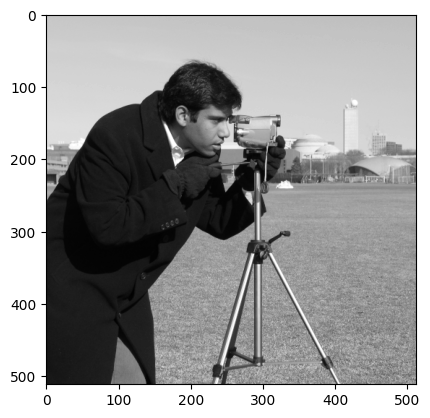

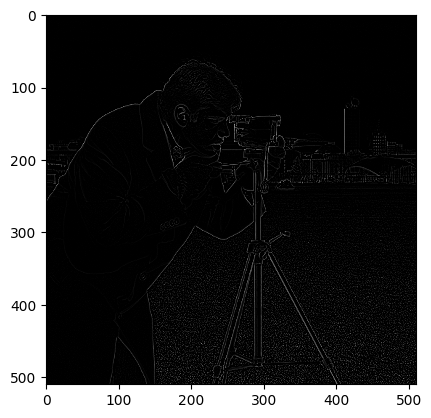

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class Filter(nn.Module):
    def __init__(self):
        super(Filter, self).__init__()
        self.conv1 = nn.Conv2d(1,1, 3)
    def setKernel(self,K):
        #self.conv1 = None
        #(in_channels, out_channels, kernel_size)
        K = torch.from_numpy(K).float()
        #move from numpy to torch
        K = torch.unsqueeze(torch.unsqueeze(K,0),0)
        #add extra dimensions for in_channels and out_channels
        self.conv1.weight.data = 0*self.conv1.weight.data + K
        #set the kernel as weights (done this way to avoid data type changes)
        self.conv1.bias.data = 0*self.conv1.bias.data
        # no bias
        return self
    def forward(self, x):
        x = self.conv1(x)
        #perform convolution
        return x

plt.close('all')
from skimage import data
X = data.camera(); plt.imshow(X,cmap='gray',vmin=0,vmax=255)

K = np.array([[0 ,1, 0],[1,-4,1], [0, 1 ,0]])

X_torch = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(X).float(),0),0)
#move image to torch
f = Filter().setKernel(K)
#set the kernel in Filter object
Z_torch = f(X_torch)
#convolution
Z = Z_torch.squeeze().detach().numpy()
#move back to numpy

plt.figure();plt.imshow(Z,cmap='gray',vmin=0,vmax=255)

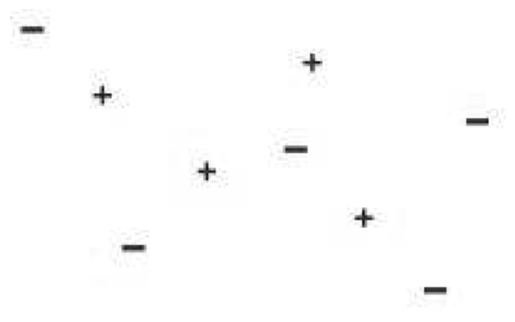

In [15]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
# URL of the raw image hosted on GitHub https://github.com/foxtrotmike/CS909/blob/master/in.jpg
image_url = 'https://raw.githubusercontent.com/foxtrotmike/CS909/master/in.jpg'
# Use requests to fetch the image
response = requests.get(image_url)
# Make sure the request was successful
if response.status_code == 200:
    # Open the image from the binary response content
    image = Image.open(BytesIO(response.content))
else:
    print("Failed to fetch image")

import matplotlib.pyplot as plt
# Display the image using matplotlib
plt.imshow(image,cmap='gray')
plt.axis('off')  # Hide axis
plt.show()


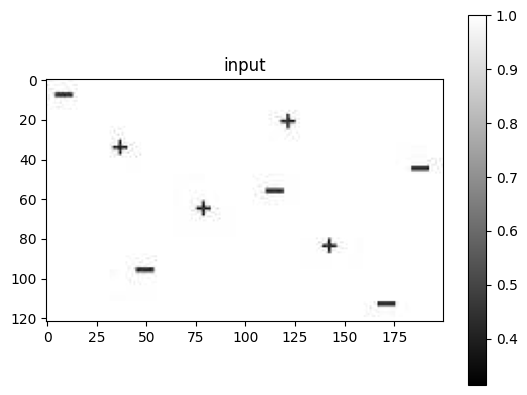

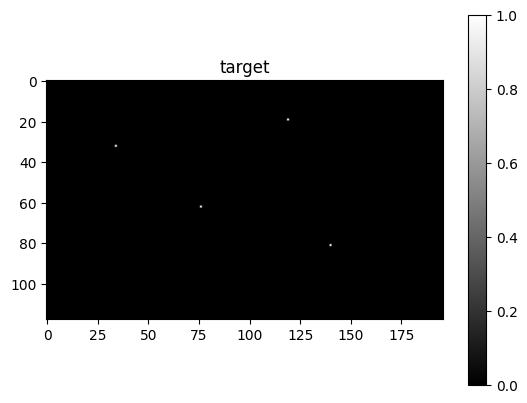

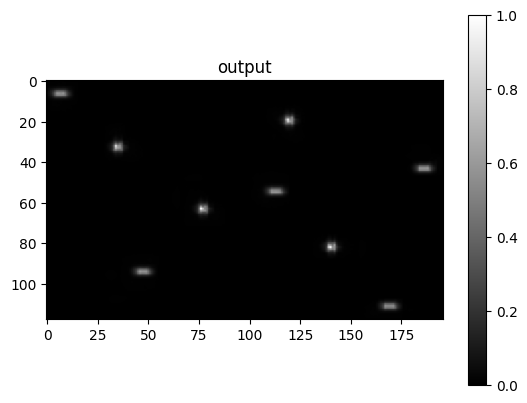

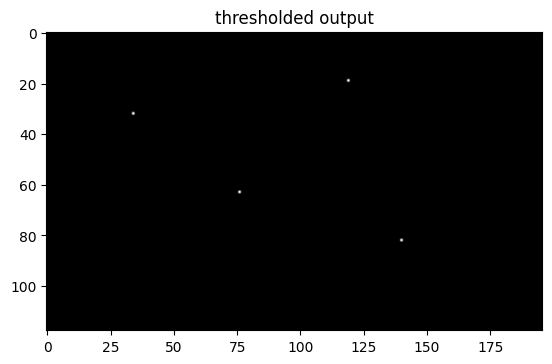

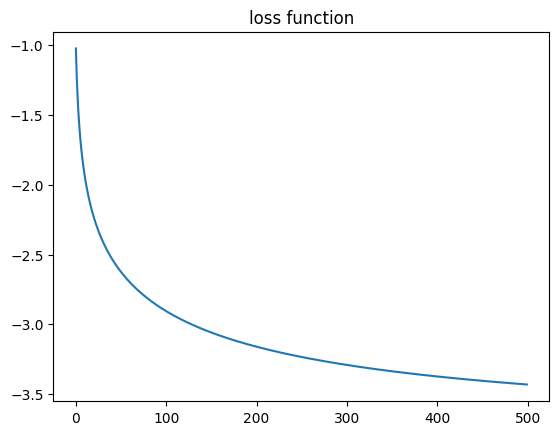

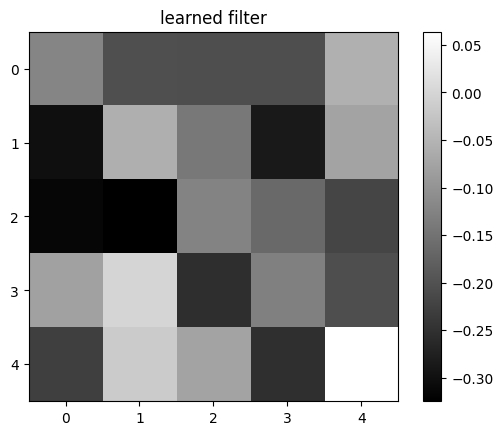

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
plt.close('all')
class Filter(nn.Module):
    def __init__(self):
        super(Filter, self).__init__()
        self.conv1 = nn.Conv2d(1,1, 5)

    def forward(self, x):
        x = self.conv1(x)
        #perform convolution
        return x

#import skimage
X = np.array(image)/255.0
T = np.zeros(X.shape,dtype=np.float64) #create the target by putting 1.0 at target object locations
T[21,121]=1.0
T[34,36] =1.0
T[64,78] =1.0
T[83,142]=1.0

T = T[2:-2,2:-2] # reduce target filter size to compensate for padding loss in convolution
f = Filter()
optimizer = torch.optim.SGD(f.parameters(), lr=1e-1)
T_torch = torch.from_numpy(T).float()
X_torch = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(X).float(),0),0)
L = []
for _ in range(500):
    Z_torch = f(X_torch).squeeze()
    Z_torch = torch.sigmoid(Z_torch) #output
    #Z_torch = (Z_torch-torch.min(Z_torch))/(torch.max(Z_torch)-torch.min(Z_torch)) #rescale
    loss = torch.mean((T_torch-Z_torch)**2) #error

    optimizer.zero_grad() #optimization
    loss.backward()
    optimizer.step()
    L.append(loss.item())

output = Z_torch.squeeze().detach().numpy()
output = output**2 #contrast stretching
output = (output-np.min(output))/(np.max(output)-np.min(output)) #rescale

plt.figure();plt.imshow(X,cmap='gray');plt.title('input');plt.colorbar()
plt.figure();plt.imshow(T,cmap='gray');plt.title('target');plt.colorbar()
plt.figure();plt.imshow(output,cmap='gray');plt.title('output');plt.colorbar()
plt.figure();plt.imshow(output>0.8,cmap='gray');plt.title('thresholded output')
plt.figure();plt.plot(np.log10(L));plt.title('loss function')
plt.figure();plt.imshow(f.conv1.weight.squeeze().detach().numpy(),cmap='gray');plt.title('learned filter');plt.colorbar()